# Assignment 1

## Question `2` (Decision Trees)

| | |
|-|-|
| Course | Statistical Methods in AI |
| Release Date | `19.01.2023` |
| Due Date | `29.01.2023` |

This assignment will have you working and experimenting with decision trees. Initially, you will be required to implement a decision tree classifier by choosing thresholds based on various impurity measures and reporting the scores. Later, you can experiment with the `scikit-learn` implementation of decision trees, and how various other parameters can be leveraged for better performance.

The dataset is a very simple one, the [banknote authentication dataset](https://archive.ics.uci.edu/ml/datasets/banknote+authentication). It has 5 columns, the first 4 are the features, and the last one is the class label. The features are the variance, skewness, curtosis and entropy of the [wavelet transformed](https://en.wikipedia.org/wiki/Wavelet_transform) image of the banknote. The class label is 1 if the banknote is authentic, and 0 if it is forged. The data is present in `bankAuth.txt`. There are a total of 1372 samples in the dataset.

### Imports

In [6]:
%matplotlib inline

In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# additional imports if necessary

### Impurity Measures

Decision trees are only as good as the impurity measure used to choose the best split. In this section, you will be required to implement the following impurity measures and use them to build a decision tree classifier.

1. Gini Index
2. Entropy
3. Misclassification Error


Write functions that calculate the impurity measures for a given set of labels. The functions should take in a list of labels and return the impurity measure.

In [8]:
from math import log, e
def gini(x):
  if x.tolist().count(0) == len(x):
    return 0.0
  total = 0
  for i, xi in enumerate(x[:-1], 1):
      total += np.sum(np.abs(xi - x[i:]))
  return total / (len(x)**2 * np.mean(x))

def entropy(labels, base=None):
  value,counts = np.unique(labels, return_counts=True)
  norm_counts = counts / counts.sum()
  base = e if base is None else base
  return -(norm_counts * np.log(norm_counts)/np.log(base)).sum()

def misclassification(x):
  p = ((x == 1.0).sum())/len(x)
  return min(p, 1-p)


### Decision Tree

Fit a decision tree using any one of the above impurity measures with a depth of 3. This means you will have eight leaf nodes and seven internal nodes. Report the threshold values at each internal node and the impurity measure at the final leaf node with the label. Also report the accuracy of the classifier on the training and test data (instructions for splitting the data will be given in the end).

In [9]:
import numpy as np
import random
features = ['variance', 'skewness', 'curtosis', 'entropy']
class Node:
    def __init__(self, left=None, right=None, value=None, isleaf=None, feature=None, threshold=None, impurity=None, true=None, false=None):
        self.left = left
        self.right = right
        self.isleaf = isleaf        
        self.value = value
        self.feature = feature
        self.threshold = threshold
        self.impurity = impurity
        self.true = true
        self.false = false

class Tree:
    def __init__(self, rec = dict()):
        self.root=None
        self.rec = rec
    def buildTree(self, X, y, height, ind):
      entropy_parent = entropy(y)
      X_len = X.shape[0]
      true_count = (y==1).sum()

      if height == 3 or true_count == X_len or true_count == 0 or X_len < 2:
        if true_count > X_len/2:
          val = 1
        else:
          val = 0
        temp_node = Node(impurity = entropy_parent, value=val, isleaf=True, true=true_count, false=X_len-true_count)
        self.rec[ind] = temp_node
        return temp_node
      
      else:
        gain = -float('inf')
        fselect = None
        thrsh = None
        partition1 = None
        partition2 = None
        fid = [0, 1, 2, 3]
        random.shuffle(fid)
  
        for id in fid:
          fColumn = X[:, id]

          for possible_split in fColumn:
            less_ind = np.argwhere(fColumn<=possible_split).ravel()
            greater_ind = np.argwhere(fColumn>possible_split).ravel()

            if len(less_ind) == 0 or len(greater_ind) == 0:
              split_gain = 0

            else:
              split_gain = entropy_parent - (len(less_ind) * entropy(y[less_ind]) + len(greater_ind) * entropy(y[greater_ind]))/X_len
            
            if split_gain > gain:
              gain = split_gain
              fselect = id
              thrsh = possible_split
              partition1 = less_ind
              partition2 = greater_ind

        temp_node = Node(feature = fselect, threshold = thrsh, isleaf=False, impurity=entropy_parent, true=true_count, false=X_len-true_count)
        temp_node.left = self.buildTree(X[partition1, :], y[partition1], height+1, ind*2+1)
        temp_node.right = self.buildTree(X[partition2, :], y[partition2], height+1, ind*2+2)
        self.rec[ind] = temp_node
        return temp_node

    def findLeafVal(self, row):
      root = self.root
      while root.isleaf == False:
        if row[root.feature] <= root.threshold:
          root = root.left
        else:
          root = root.right

      return root.value

    def predict(self, X):
      predictions = [self.findLeafVal(row) for row in X]
      return predictions

In [10]:
from sklearn import datasets
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
data = pd.read_csv('bankAuth.txt', names = ['variance', 'skewness', 'curtosis', 'entropy', 'label'])
X = data[['variance', 'skewness', 'curtosis', 'entropy']]
y = data[['label']]
X = np.array(X)
y = np.array(y)
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state = 1000)

In [11]:
from sklearn.metrics import accuracy_score
tree = Tree()
tree.root = tree.buildTree(X_train, y_train, 0, 0)

predictions = tree.predict(X_test)
print('accuracy= ', accuracy_score(predictions, y_test))

accuracy=  0.96


In [12]:
keys = sorted(tree.rec.keys())
print(keys)
for ind in keys:
  if tree.rec[ind].isleaf == False:
    print(f'Threshold value at internal node with index {ind} is {tree.rec[ind].threshold}')
  else:
    print(f'Impurity value and label of leaf node with index {ind} is {tree.rec[ind].impurity}, {tree.rec[ind].value}')

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
Threshold value at internal node with index 0 is 0.75896
Threshold value at internal node with index 1 is 5.1401
Threshold value at internal node with index 2 is 2.2279
Threshold value at internal node with index 3 is 0.31803
Threshold value at internal node with index 4 is -3.9934
Threshold value at internal node with index 5 is -2.3
Impurity value and label of leaf node with index 6 is -0.0, 0
Impurity value and label of leaf node with index 7 is 0.20729029989695702, 1
Impurity value and label of leaf node with index 8 is 0.6907671705264811, 1
Impurity value and label of leaf node with index 9 is 0.1461447460085638, 1
Impurity value and label of leaf node with index 10 is 0.056001534354847345, 0
Impurity value and label of leaf node with index 11 is 0.3893772362904818, 1
Impurity value and label of leaf node with index 12 is 0.08420385103978328, 0


### `sklearn` Decision Tree Experiments

1. Scikit-learn has two decision tree implementations: [`DecisionTreeClassifier`](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html) and [`DecisionTreeRegressor`](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeRegressor.html). 

When would you use one over the other? What would you use in the case of the banknote authentication dataset? Explain the changes that need to be made in the dataset to use the other implementation.

2. Fit a decision tree to the training set. Change various parameters and compare them to one another. Mainly try and experiment with the `criterion`, `max_depth` and `min_samples_split` parameters. Report the accuracy on the training and test set for each of the experiments while varying the parameters for comparison purposes.

3. Plot your trees !! (optional) (for visualization)

```python
from sklearn.tree import plot_tree

def plotTree(tree):
    """
    tree: Tree instance that is the result of fitting a DecisionTreeClassifier
          or a DecisionTreeRegressor.
    """
    plt.figure(figsize=(30,20))
    plot_tree(tree, filled=True, rounded=True,
                  class_names=['forged', 'authentic'],
                  feature_names=['var', 'skew', 'curt', 'ent'])
    plt.show()
    return None
```

In [13]:
from sklearn.tree import plot_tree

def plotTree(tree):
    """
    tree: Tree instance that is the result of fitting a DecisionTreeClassifier
          or a DecisionTreeRegressor.
    """
    plt.figure(figsize=(30,20))
    plot_tree(tree, filled=True, rounded=True,
                  class_names=['forged', 'authentic'],
                  feature_names=['var', 'skew', 'curt', 'ent'])
    plt.show()
    return None

### Load Data

The data has been loaded onto a Pandas DataFrame. Try to get an initial feel for the data by using functions like `describe()`, `info()`, or maybe try to plot the data to check for any patterns.

Note: To obtain the data from the UCI website, `wget` can be used followed by shuffling the samples using `shuf` and adding a header for easier reading via `pandas`. It is not necessary to view the data in a DataFrame and can be directly loaded onto NumPy as convenient.

In [14]:
data = pd.read_csv('bankAuth.txt', names = ['variance', 'skewness', 'curtosis', 'entropy', 'label'])

### Splitting the Data

It is a good practice to split the data into training and test sets. This is to ensure that the model is not overfitting to the training data. The test set is used to evaluate the performance of the model on unseen data. The test set is not used to train the model in any way. The test set is only used to evaluate the performance of the model. You may use the `train_test_split` function from `sklearn.model_selection` to split the data into training and test sets.

It is a good idea to move your data to NumPy arrays now as it will make computing easier.

In [15]:
from sklearn.model_selection import train_test_split
X = data[['variance', 'skewness', 'curtosis', 'entropy']]
y = data[['label']]
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.80, random_state=1000)

### Denouement

Use this place to report all comparisons and wrap up the calls to the functions written above.

*DecisionTreeClassifier() is used when we have categorical labels to predict like (True, False), (0, 1), (category1, category2, ....)
In this question our labels are (0, 1) that means its categorical, so we should use  DecisionTreeClassifier().*

0.9927272727272727


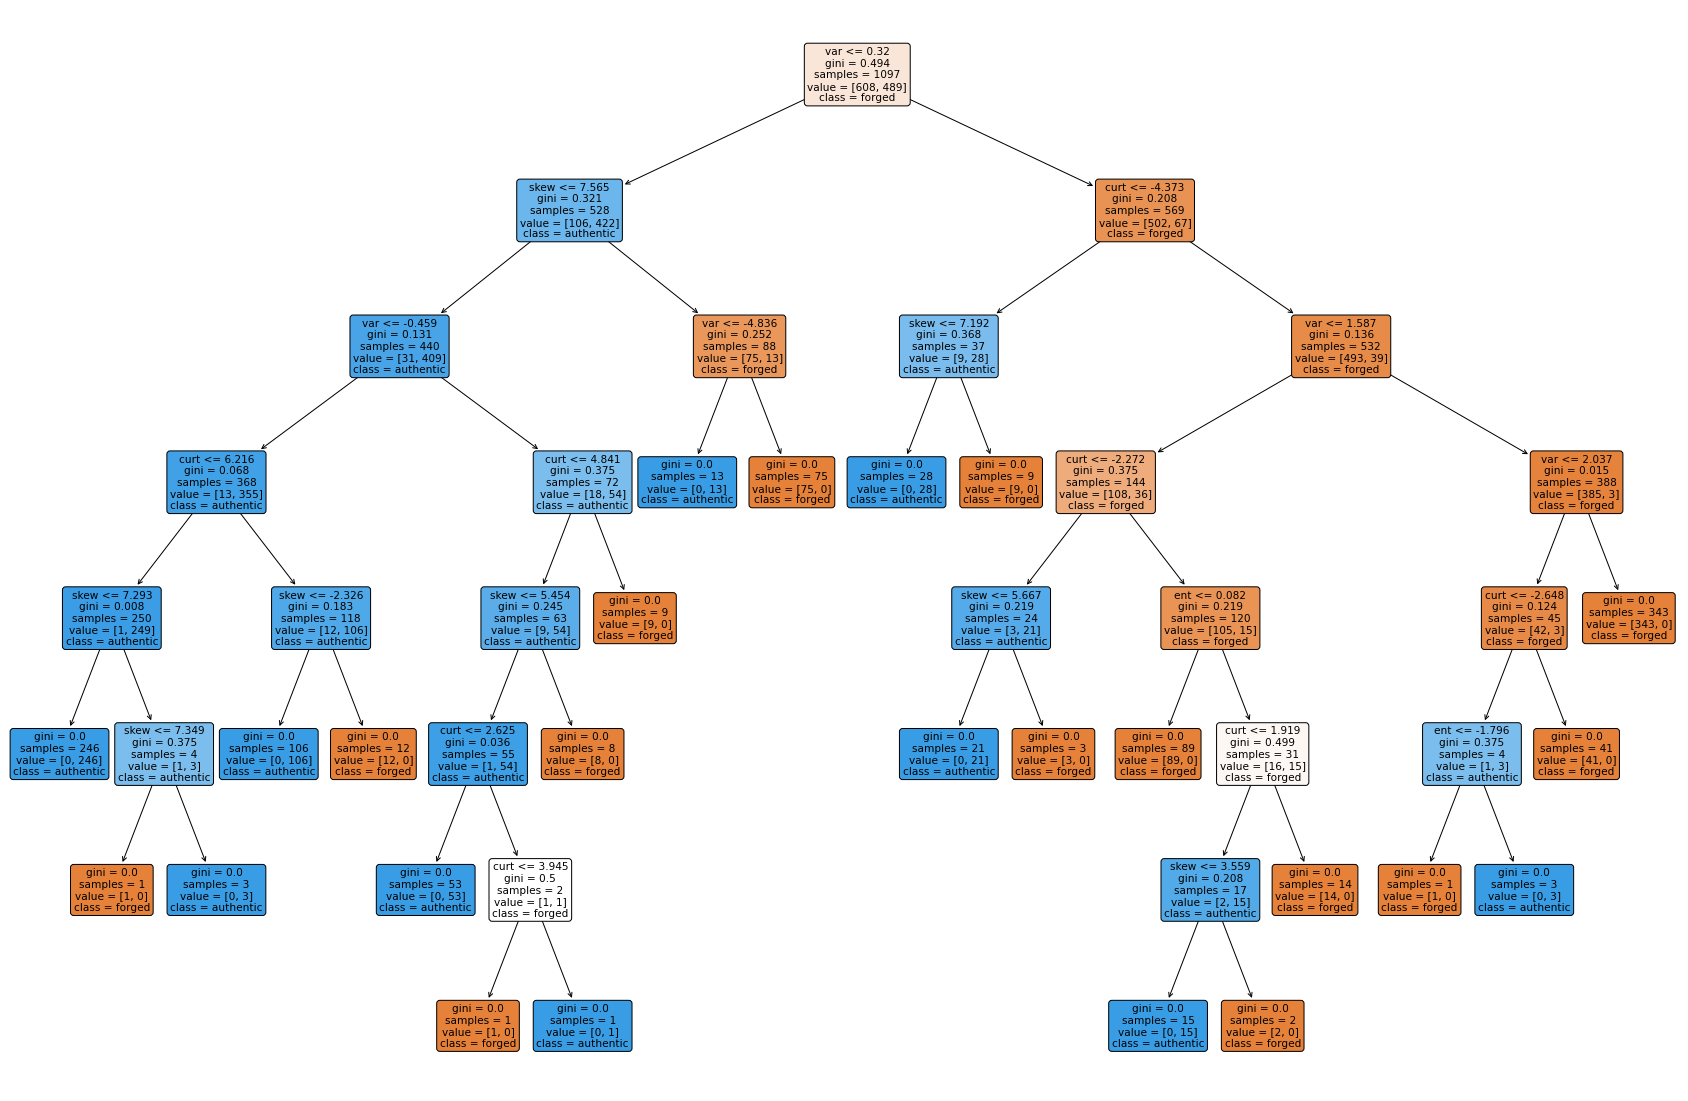

In [16]:
from sklearn import tree
from sklearn.model_selection import train_test_split
from sklearn import metrics
clf = tree.DecisionTreeClassifier()
clf = clf.fit(X_train, y_train)
p = clf.predict(X_test)
print(metrics.accuracy_score(p, y_test))
plotTree(clf)

*A DecisionTreeRegressor() is used when we have continous value labels to predict. And the predictions will be continous values in a range, to use DecisionTreeRegressor() in this problem we can convert the predicted range values to categories 0 and 1 based on when it is greater than a certain threshold say 0.5.*

0.9927272727272727


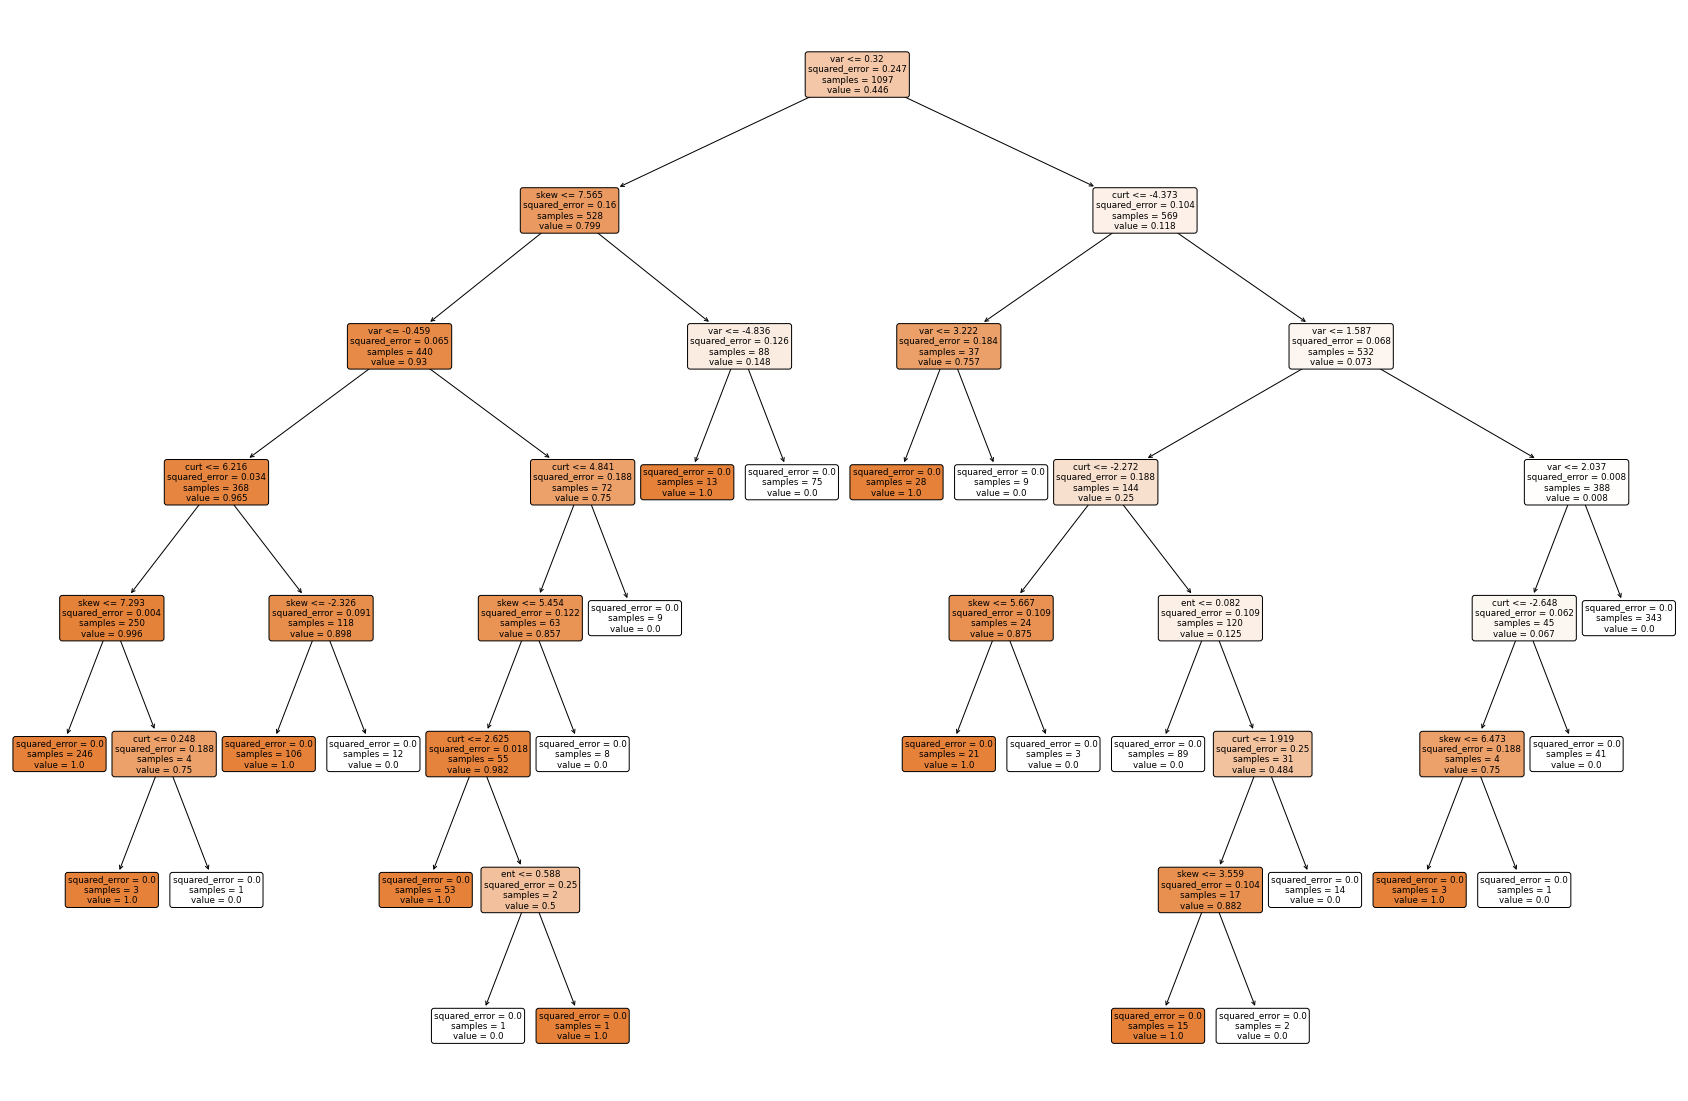

In [17]:
from sklearn import tree
from sklearn.model_selection import train_test_split
from sklearn import metrics
clf = tree.DecisionTreeRegressor()
clf = clf.fit(X_train, y_train)
p = clf.predict(X_test)
# changing values in the range [0, 0.5] to 0 and values in the range (0.5, 1] to 1
p = [1 * (val > 0.5) for val in p]
print(metrics.accuracy_score(p, y_test))
plotTree(clf)

In [18]:
from sklearn import tree
from sklearn.model_selection import train_test_split
from sklearn import metrics
gini_scores = []
entropy_scores = []
log_loss_scores = []
iteration = list(range(1, 101))
for i in iteration:
  clf = tree.DecisionTreeClassifier(criterion='gini')
  clf = clf.fit(X_train, y_train)
  p = clf.predict(X_test)
  gini_scores.append(metrics.accuracy_score(p, y_test))
  clf = tree.DecisionTreeClassifier(criterion='entropy')
  clf = clf.fit(X_train, y_train)
  p = clf.predict(X_test)
  entropy_scores.append(metrics.accuracy_score(p, y_test))
  
gini_min, gini_max = min(gini_scores), max(gini_scores)
entropy_min, entropy_max = min(entropy_scores), max(entropy_scores)
print('gini--> \nmin: ', gini_min, '\nmax: ', gini_max, '\naverage: ', sum(gini_scores)/100)
print()
print('entropy--> \nmin: ', entropy_min, '\nmax: ', entropy_max, '\naverage: ', sum(entropy_scores)/100)

gini--> 
min:  0.9927272727272727 
max:  0.9927272727272727 
average:  0.9927272727272748

entropy--> 
min:  0.9927272727272727 
max:  0.9927272727272727 
average:  0.9927272727272748


*Upon running the model with each criterion 100 times, we see that the maximum, minimum and average accuracy produced by each criterion is very close and similar.*

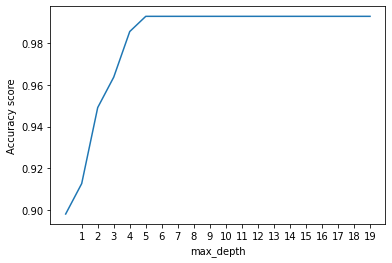

In [19]:
from sklearn import tree
from sklearn.model_selection import train_test_split
from sklearn import metrics
scores = []
depth_range = list(range(1, 21))
for depth in range(1, 21):
  clf = tree.DecisionTreeClassifier(max_depth = depth)
  clf = clf.fit(X_train, y_train)
  p = clf.predict(X_test)
  scores.append(metrics.accuracy_score(p, y_test))
plt.xlabel('max_depth')
plt.ylabel('Accuracy score')
plt.xticks(np.arange(min(depth_range), max(depth_range)+1, 1))
plt.plot(scores)
plt.show()

*Prediction accuracy increases with incerease of max_depth.*

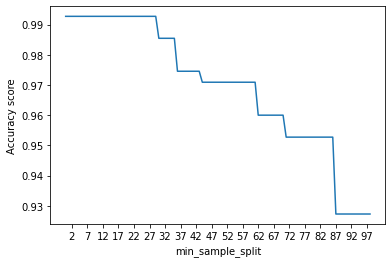

In [20]:
from sklearn import tree
from sklearn.model_selection import train_test_split
from sklearn import metrics
scores = []
split_range = list(range(2, 101))
for split in split_range:
  clf = tree.DecisionTreeClassifier(min_samples_split=split)
  clf = clf.fit(X_train, y_train)
  p = clf.predict(X_test)
  scores.append(metrics.accuracy_score(p, y_test))
plt.xlabel('min_sample_split')
plt.ylabel('Accuracy score')
plt.xticks(np.arange(min(split_range), max(split_range)+1, 5))
plt.plot(scores)
plt.show()

*We see that lower(atleast 2) the min_sample_split higher the accuracy, and accuracy reduces as we increase min_sample_split.*